In [13]:
# ========================================
# CELL 1: KIỂM TRA GPU
# ========================================
!nvidia-smi

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print(f"\nTensorFlow: {tf.__version__}")
print(f"GPUs: {gpus}")

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU ENABLED!")
else:
    print("❌ NO GPU! Go to Runtime → Change runtime type → GPU")

Thu Feb  5 10:03:03 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             29W /   70W |    4220MiB /  15360MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
# ========================================
# CELL 2: IMPORT LIBRARIES
# ========================================
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
import pickle
import json
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

print("✅ Libraries imported!")

✅ Libraries imported!


In [16]:
# ========================================
# CELL 3: MOUNT DRIVE
# ========================================
from google.colab import drive
drive.mount('/content/drive')
print("✅ Drive mounted!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted!


In [ ]:
# ========================================
# CELL 3B: TẠO FILE ZIP - CHỈ CHẠY 1 LẦN!
# ⚠️ Sau khi chạy xong, KHÔNG CẦN chạy lại cell này nữa!
# ========================================
import os

DATASET_PATH = '/content/drive/MyDrive/CaptoneProject/camera'
ZIP_PATH = '/content/drive/MyDrive/CaptoneProject/camera.zip'

if os.path.exists(ZIP_PATH):
    print(f"✅ ZIP đã tồn tại! Bỏ qua cell này.")
    !ls -lh "{ZIP_PATH}"
else:
    print("📦 Đang tạo ZIP (~2-3 phút)...")
    !cd /content/drive/MyDrive/CaptoneProject && zip -r camera.zip camera
    print("✅ ZIP đã tạo xong!")
    !ls -lh "{ZIP_PATH}"

print("\n💡 Từ giờ, bỏ qua cell này và chạy CELL 4!")

In [ ]:
# ========================================
# CELL 4: GIẢI NÉN TỪ ZIP + SET PATHS
# ========================================
import os
import shutil

ZIP_PATH = '/content/drive/MyDrive/CaptoneProject/camera.zip'
LOCAL_PATH = '/content/dataset'
CHECKPOINT_DIR = '/content/drive/MyDrive/CaptoneProject/checkpoints'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

if not os.path.exists(LOCAL_PATH):
    if os.path.exists(ZIP_PATH):
        print("📦 Giải nén từ ZIP (~30 giây)...")
        !unzip -q "{ZIP_PATH}" -d /content/

        # Debug: xem nội dung sau khi giải nén
        print("\n🔍 DEBUG: Nội dung /content/ sau khi giải nén:")
        !ls -la /content/

        # Xác định cấu trúc và move đúng
        if os.path.exists('/content/camera'):
            # Trường hợp 1: ZIP chứa folder "camera"
            print("\n📂 Tìm thấy /content/camera → Di chuyển...")
            !mv /content/camera "{LOCAL_PATH}"
            print("✅ Done!")

        elif os.path.exists('/content/train') and os.path.exists('/content/test'):
            # Trường hợp 2: ZIP chứa trực tiếp train/test
            print("\n📂 Tìm thấy /content/train và /content/test → Di chuyển...")
            os.makedirs(LOCAL_PATH, exist_ok=True)
            !mv /content/train "{LOCAL_PATH}/train"
            !mv /content/test "{LOCAL_PATH}/test"
            print("✅ Done!")

        elif os.path.exists('/content/dataset'):
            # Trường hợp 3: ZIP đã giải nén thành dataset
            print("\n📂 Tìm thấy /content/dataset → Đã sẵn sàng!")
            print("✅ Done!")

        else:
            # Không tìm thấy cấu trúc mong đợi
            print("\n❌ Không tìm thấy cấu trúc dataset mong đợi!")
            print("Nội dung hiện tại:")
            !ls -la /content/
            print("\n⚠️ Vui lòng kiểm tra lại cấu trúc file ZIP.")
    else:
        print("❌ Không tìm thấy ZIP!")
        print(f"   Đường dẫn: {ZIP_PATH}")
        print("   → Chạy CELL 3B để tạo ZIP trước.")
else:
    print("✅ Dataset đã có sẵn!")

# Set paths
TRAIN_DIR = os.path.join(LOCAL_PATH, 'train')
TEST_DIR = os.path.join(LOCAL_PATH, 'test')

print(f"\n📁 Train: {TRAIN_DIR}")
print(f"📁 Test: {TEST_DIR}")

# Kiểm tra và đếm files
if os.path.exists(TRAIN_DIR):
    total = 0
    print("\n📊 Phân bố dữ liệu:")
    for folder in sorted(os.listdir(TRAIN_DIR)):
        folder_path = os.path.join(TRAIN_DIR, folder)
        if os.path.isdir(folder_path):
            count = len(os.listdir(folder_path))
            total += counta

            print(f"   {folder}: {count}")
    print(f"\n📊 Total: {total} training images")
else:
    print("\n❌ TRAIN_DIR không tồn tại!")
    print("   Kiểm tra lại cấu trúc giải nén ở trên.")

In [ ]:
# ========================================
# CELL 5: CẤU HÌNH
# ========================================
IMG_SIZE = 48
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.0005
NUM_CLASSES = 7

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths cho checkpoint
MODEL_CHECKPOINT_PATH = f'{CHECKPOINT_DIR}/emotion_model_checkpoint.keras'
BEST_MODEL_PATH = f'{CHECKPOINT_DIR}/emotion_best_model.keras'
HISTORY_PATH = f'{CHECKPOINT_DIR}/training_history.pkl'
CONFIG_PATH = f'{CHECKPOINT_DIR}/config.json'

# Lưu config
config = {
    'IMG_SIZE': IMG_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'NUM_CLASSES': NUM_CLASSES,
    'EMOTIONS': EMOTIONS
}
with open(CONFIG_PATH, 'w') as f:
    json.dump(config, f)

print("✅ Config set and saved!")
print(f"   Image: {IMG_SIZE}x{IMG_SIZE} | Batch: {BATCH_SIZE} | LR: {LEARNING_RATE}")

In [ ]:
# ========================================
# CELL 6: DATA GENERATORS
# ========================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("📂 Loading data from LOCAL storage...")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✅ Train: {train_generator.samples} | Val: {validation_generator.samples} | Test: {test_generator.samples}")

In [ ]:
# ========================================
# CELL 7: CLASS WEIGHTS
# ========================================
train_labels = train_generator.classes
class_weights_array = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights_array))

print("📊 Class Weights:")
for idx, emotion in enumerate(EMOTIONS):
    print(f"   {emotion}: {class_weights[idx]:.3f}")

In [ ]:
# ========================================
# CELL 8: BUILD MODEL (hoặc LOAD TỪ CHECKPOINT)
# ========================================

def build_cnn(input_shape=(48, 48, 1), num_classes=7):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 4
        layers.Conv2D(512, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(512, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Classifier
        layers.Flatten(),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),
        layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Kiểm tra có checkpoint không
initial_epoch = 0
history_data = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': [], 'lr': []}

if os.path.exists(MODEL_CHECKPOINT_PATH):
    print("📂 Found checkpoint! Loading...")
    model = keras.models.load_model(MODEL_CHECKPOINT_PATH)

    # Load history
    if os.path.exists(HISTORY_PATH):
        with open(HISTORY_PATH, 'rb') as f:
            history_data = pickle.load(f)
        initial_epoch = len(history_data['accuracy'])
        print(f"✅ Resuming from epoch {initial_epoch}")
        print(f"   Last val_accuracy: {history_data['val_accuracy'][-1]*100:.2f}%")
else:
    print("🆕 No checkpoint found. Building new model...")
    model = build_cnn()
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

print(f"\n✅ Model ready: {model.count_params():,} parameters")
model.summary()

In [ ]:
# ========================================
# CELL 9: CALLBACKS VỚI AUTO-SAVE
# ========================================

# Custom callback để lưu history sau mỗi epoch
class SaveHistoryCallback(keras.callbacks.Callback):
    def __init__(self, history_path, checkpoint_path):
        super().__init__()
        self.history_path = history_path
        self.checkpoint_path = checkpoint_path
        self.history_data = history_data  # Sử dụng history đã load

    def on_epoch_end(self, epoch, logs=None):
        # Cập nhật history
        self.history_data['accuracy'].append(logs.get('accuracy'))
        self.history_data['val_accuracy'].append(logs.get('val_accuracy'))
        self.history_data['loss'].append(logs.get('loss'))
        self.history_data['val_loss'].append(logs.get('val_loss'))
        self.history_data['lr'].append(float(self.model.optimizer.learning_rate.numpy()))

        # Lưu history
        with open(self.history_path, 'wb') as f:
            pickle.dump(self.history_data, f)

        # Lưu model checkpoint
        self.model.save(self.checkpoint_path)
        print(f"   💾 Checkpoint saved to Drive!")

callbacks = [
    # Lưu best model
    ModelCheckpoint(
        filepath=BEST_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    # Early stopping
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce LR
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    # Auto-save sau mỗi epoch
    SaveHistoryCallback(HISTORY_PATH, MODEL_CHECKPOINT_PATH)
]

print("✅ Callbacks configured with AUTO-SAVE!")
print(f"   📁 Checkpoint: {MODEL_CHECKPOINT_PATH}")
print(f"   📁 Best model: {BEST_MODEL_PATH}")
print(f"   📁 History: {HISTORY_PATH}")

In [12]:
# ========================================
# CELL 10: TRAINING (CÓ THỂ RESUME)
# ========================================
print("🚀 Starting Training...")
print("="*50)

if initial_epoch > 0:
    print(f"⏩ RESUMING from epoch {initial_epoch}")
else:
    print("🆕 Starting from scratch")

print(f"   Epochs: {initial_epoch} → {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print("="*50)

train_generator.reset()
validation_generator.reset()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,  # Resume từ epoch đã train
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n" + "="*50)
print("✅ TRAINING COMPLETED!")
print("="*50)

🚀 Starting Training...
🆕 Starting from scratch
   Epochs: 0 → 50
   Batch size: 64
Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.1598 - loss: 3.5237
Epoch 1: val_accuracy improved from -inf to 0.01515, saving model to /content/drive/MyDrive/CaptoneProject/checkpoints/emotion_best_model.keras
   💾 Checkpoint saved to Drive!
359/359 ━━━━━━━━━━━━━━━━━━━━ 68s 128ms/step - accuracy: 0.1598 - loss: 3.5233 - val_accuracy: 0.0152 - val_loss: 3.2138 - learning_rate: 5.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1638 - loss: 3.0463
Epoch 2: val_accuracy improved from 0.01515 to 0.17854, saving model to /content/drive/MyDrive/CaptoneProject/checkpoints/emotion_best_model.keras
   💾 Checkpoint saved to Drive!
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.1638 - loss: 3.0461 - val_accuracy: 0.1785 - val_loss: 2.7028 - learning_rate: 5.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.1701 - loss: 2.7024
Epoch

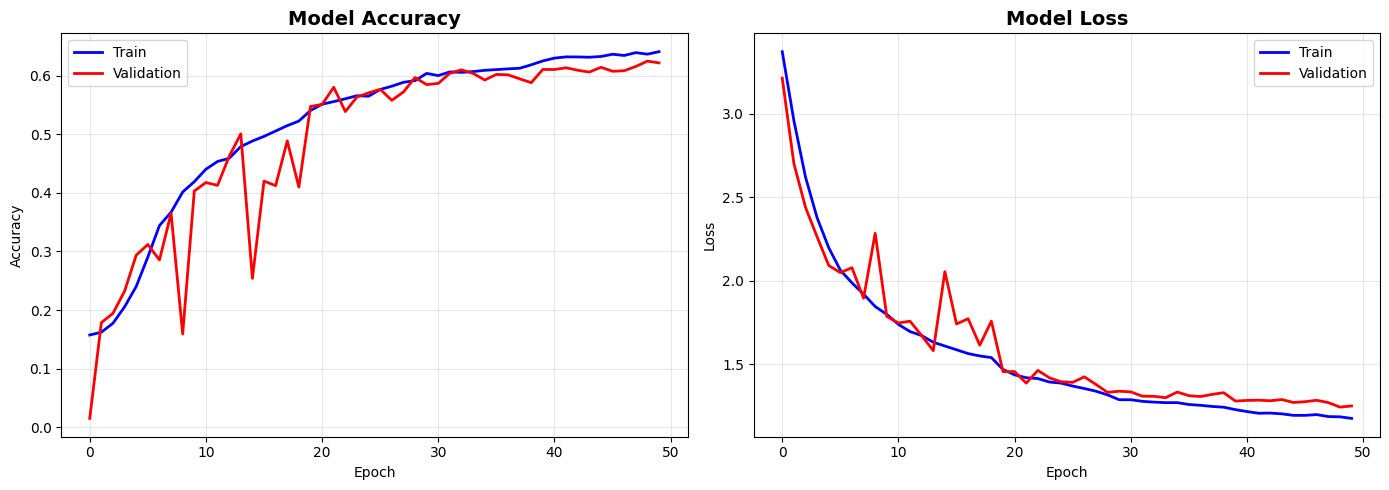


🏆 Best Epoch: 49
   Best Val Accuracy: 62.48%


In [17]:
# ========================================
# CELL 11: VẼ TRAINING CURVES
# ========================================

# Load full history từ file
with open(HISTORY_PATH, 'rb') as f:
    full_history = pickle.load(f)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(full_history['accuracy'], 'b-', linewidth=2, label='Train')
axes[0].plot(full_history['val_accuracy'], 'r-', linewidth=2, label='Validation')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(full_history['loss'], 'b-', linewidth=2, label='Train')
axes[1].plot(full_history['val_loss'], 'r-', linewidth=2, label='Validation')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{CHECKPOINT_DIR}/training_curves.png', dpi=150)
plt.show()

# Print best results
best_epoch = np.argmax(full_history['val_accuracy'])
print(f"\n🏆 Best Epoch: {best_epoch + 1}")
print(f"   Best Val Accuracy: {full_history['val_accuracy'][best_epoch]*100:.2f}%")

In [18]:
# ========================================
# CELL 12: EVALUATE TRÊN TEST SET
# ========================================

# Load best model
print("📂 Loading best model...")
best_model = keras.models.load_model(BEST_MODEL_PATH)

print("\n📊 Evaluating on Test Set...")
test_generator.reset()
test_loss, test_acc = best_model.evaluate(test_generator)

print("\n" + "="*50)
print(f"🎯 TEST ACCURACY: {test_acc*100:.2f}%")
print(f"📉 TEST LOSS: {test_loss:.4f}")
print("="*50)

📂 Loading best model...

📊 Evaluating on Test Set...
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5967 - loss: 1.3034

🎯 TEST ACCURACY: 64.22%
📉 TEST LOSS: 1.2227


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry     0.5598    0.5908    0.5749       958
     disgust     0.4823    0.6126    0.5397       111
        fear     0.5542    0.3047    0.3932      1024
       happy     0.8890    0.8354    0.8614      1774
     neutral     0.5179    0.7518    0.6133      1233
         sad     0.5526    0.4507    0.4965      1247
    surprise     0.7007    0.8339    0.7615       831

    accuracy                         0.6422      7178
   macro avg     0.6081    0.6257    0.6058      7178
weighted avg     0.6470    0.6422    0.6338      7178


📊 PER-CLASS ACCURACY:
   angry     :  59.1% (566/958)
   disgust   :  61.3% (68/111)
   fear      :  30.5% (312/1024)
   happy     :  83.5% (1482/1774)
   neutral   :  75.2% (927/1233)
   sad       :  45.1% (562/1247)
   surprise  :  83.4% (693/831)


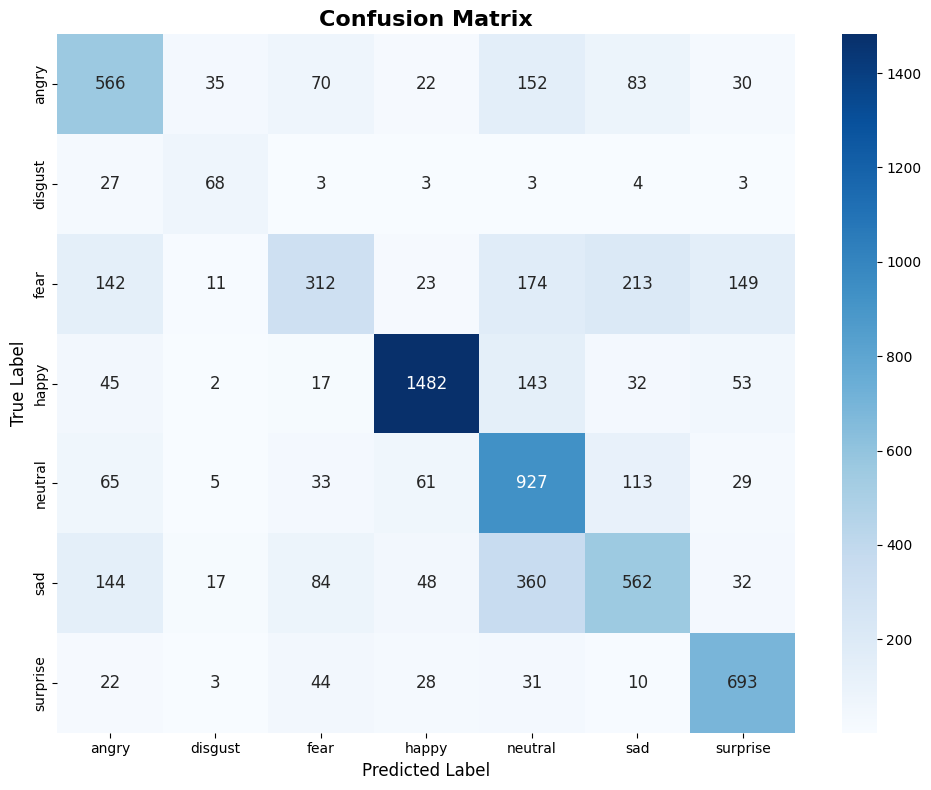

In [19]:
# ========================================
# CELL 13: CONFUSION MATRIX + CLASSIFICATION REPORT
# ========================================

# Predictions
test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification Report
print("\n📋 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=EMOTIONS, digits=4))

# Per-class accuracy
print("\n📊 PER-CLASS ACCURACY:")
for i, emotion in enumerate(EMOTIONS):
    class_total = np.sum(y_true == i)
    class_correct = np.sum((y_true == i) & (y_pred == i))
    class_acc = class_correct / class_total * 100 if class_total > 0 else 0
    print(f"   {emotion:10s}: {class_acc:5.1f}% ({class_correct}/{class_total})")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=EMOTIONS, yticklabels=EMOTIONS,
            annot_kws={'size': 12})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'{CHECKPOINT_DIR}/confusion_matrix.png', dpi=150)
plt.show()

In [20]:
# ========================================
# CELL 14: LƯU MODEL FINAL VÀO DRIVE
# ========================================

FINAL_SAVE_DIR = '/content/drive/MyDrive/CaptoneProject/trained_models'
os.makedirs(FINAL_SAVE_DIR, exist_ok=True)

# Copy all files
print("💾 Saving final model and files to Drive...")

# 1. Best model
shutil.copy(BEST_MODEL_PATH, f'{FINAL_SAVE_DIR}/emotion_model_final.keras')
print(f"   ✅ Model: {FINAL_SAVE_DIR}/emotion_model_final.keras")

# 2. Training curves
shutil.copy(f'{CHECKPOINT_DIR}/training_curves.png', f'{FINAL_SAVE_DIR}/')
print(f"   ✅ Training curves saved")

# 3. Confusion matrix
shutil.copy(f'{CHECKPOINT_DIR}/confusion_matrix.png', f'{FINAL_SAVE_DIR}/')
print(f"   ✅ Confusion matrix saved")

# 4. Training history as CSV
history_df = pd.DataFrame(full_history)
history_df.to_csv(f'{FINAL_SAVE_DIR}/training_history.csv', index=False)
print(f"   ✅ History CSV saved")

# 5. Config
shutil.copy(CONFIG_PATH, f'{FINAL_SAVE_DIR}/')
print(f"   ✅ Config saved")

# 6. Summary
summary = {
    'best_epoch': int(best_epoch + 1),
    'best_val_accuracy': float(full_history['val_accuracy'][best_epoch]),
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'total_epochs': len(full_history['accuracy']),
    'model_params': model.count_params()
}
with open(f'{FINAL_SAVE_DIR}/summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print(f"   ✅ Summary saved")

print("\n" + "="*50)
print("✅ ALL FILES SAVED!")
print("="*50)
print(f"📁 Location: {FINAL_SAVE_DIR}")
print(f"\nFiles saved:")
print(f"   - emotion_model_final.keras")
print(f"   - training_curves.png")
print(f"   - confusion_matrix.png")
print(f"   - training_history.csv")
print(f"   - config.json")
print(f"   - summary.json")

💾 Saving final model and files to Drive...
   ✅ Model: /content/drive/MyDrive/CaptoneProject/trained_models/emotion_model_final.keras
   ✅ Training curves saved
   ✅ Confusion matrix saved
   ✅ History CSV saved
   ✅ Config saved
   ✅ Summary saved

✅ ALL FILES SAVED!
📁 Location: /content/drive/MyDrive/CaptoneProject/trained_models

Files saved:
   - emotion_model_final.keras
   - training_curves.png
   - confusion_matrix.png
   - training_history.csv
   - config.json
   - summary.json


In [21]:
# ========================================
# CELL BONUS: LOAD MODEL ĐÃ TRAIN
# Chạy cell này nếu bạn muốn load model đã train xong
# ========================================

from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
import json

FINAL_SAVE_DIR = '/content/drive/MyDrive/CaptoneProject/trained_models'

# Load model
print("📂 Loading trained model...")
model = keras.models.load_model(f'{FINAL_SAVE_DIR}/emotion_model_final.keras')
print("✅ Model loaded!")

# Load summary
with open(f'{FINAL_SAVE_DIR}/summary.json', 'r') as f:
    summary = json.load(f)

print(f"\n📊 Model Summary:")
print(f"   Best Val Accuracy: {summary['best_val_accuracy']*100:.2f}%")
print(f"   Test Accuracy: {summary['test_accuracy']*100:.2f}%")
print(f"   Parameters: {summary['model_params']:,}")

# Emotions
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print(f"   Classes: {EMOTIONS}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Loading trained model...
✅ Model loaded!

📊 Model Summary:
   Best Val Accuracy: 62.48%
   Test Accuracy: 64.22%
   Parameters: 7,187,911
   Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
